In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
mean1, mean2 = np.array([-1,2]), np.array([1,-1])
mean3, mean4 = np.array([4,-4]), np.array([-4,4])
covar = np.array([[1.0, 0.8], [0.8, 1.0]])
X1 = np.random.multivariate_normal(mean1, covar, 50)
X1 = np.vstack((X1, np.random.multivariate_normal(mean3, covar, 50)))
X2 = np.random.multivariate_normal(mean2, covar, 50)
X2 = np.vstack((X2, np.random.multivariate_normal(mean4, covar, 50)))
y1 = np.ones(X1.shape[0])
y2 = -1 * np.ones(X2.shape[0])
X_train = np.vstack((X1[:80], X2[:80]))
y_train = np.hstack((y1[:80], y2[:80]))
X_test = np.vstack((X1[80:], X2[80:]))
y_test = np.hstack((y1[80:], y2[80:]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(160, 2) (160,) (40, 2) (40,)


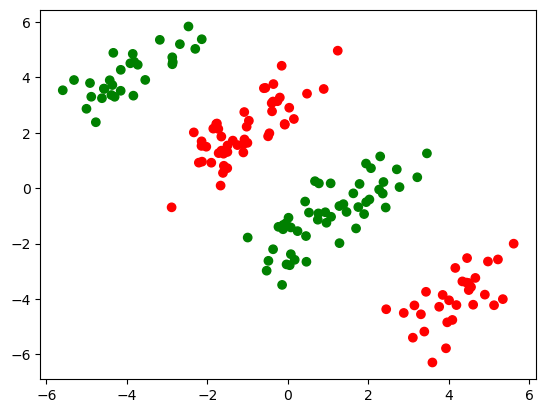

In [20]:
colors = {1:'r', -1:'g'}
plt.scatter(X_train[:,0], X_train[:,1], marker='o', c=pd.Series(y_train).map(colors))
plt.show()

In [21]:
def gaussian_kernel(x1, x2, sigma=5.0):
    return np.exp(-1*np.linalg.norm(x1-x2)**2/(2*(sigma**2)))

In [30]:
from cvxopt import matrix, solvers

class Non_linear_SVM:
    def __init__(self, kernel=gaussian_kernel) -> None:
        self.kernel = kernel    # nonlinear svm的kernel，默认为高斯核

    def _gram_matrix(self, X):
        m,n = X.shape
        K = np.zeros((m,m))
        # 遍历计算Gram矩阵
        for i in range(m):
            for j in range(m):
                K[i,j] = self.kernel(X[i], X[j])
        return K
    
    def project(self, X):
        y_pred = np.zeros(len(X))
        for i in range(X.shape[0]):
            s = 0
            for a, spv_y, spv in zip(self.a, self.spv_y, self.spv):
                s += a*spv_y*self.kernel(X[i],spv)
            y_pred[i] = s
        return y_pred + self.b
    
    def fit(self, X, y):
        m,n = X.shape

        K = self._gram_matrix(X)    # 基于linear kernel计算Gram matrix

        # 初始化二次规划相关变量
        P = matrix(np.outer(y,y)*K)
        q = matrix(-1*np.ones(m))
        A = matrix(y, (1,m))
        b = matrix(0.0)
        G = matrix(np.diag(np.ones(m)*(-1)))
        h = matrix(np.zeros(m))

        # 构建二次规划求解
        sol = solvers.qp(P,q,G,h,A,b)
        # 拉格朗日乘子
        a = np.ravel(sol['x'])
        
        # 寻找支持向量
        spv = a > 1e-5  # 阈值为0.00001
        ix = np.arange(len(a))[spv]
        self.a = a[spv]
        self.spv = X[spv]
        self.spv_y = y[spv]
        print(f'{len(self.a)} support vectors out of {m}')

        # bias
        self.b = 0
        for i in range(len(self.a)):
            self.b += self.spv_y[i]
            self.b -= np.sum(self.a*self.spv_y*K[ix[i], spv])
        self.b /= len(self.a)

        # weights 不需要显式初始化
        self.w = None

    def predict(self, X):
        return np.sign(self.project(X))
    

In [31]:
from sklearn.metrics import accuracy_score
non_linear_svm = Non_linear_SVM()
non_linear_svm.fit(X_train, y_train)
y_pred = non_linear_svm.predict(X_test)

accuracy_score(y_pred, y_test)

     pcost       dcost       gap    pres   dres
 0: -5.4175e+01 -1.5100e+02  4e+02  2e+01  2e+00
 1: -8.4655e+01 -1.6653e+02  1e+02  5e+00  6e-01
 2: -1.1841e+02 -1.9569e+02  1e+02  3e+00  4e-01
 3: -1.7109e+02 -2.3656e+02  8e+01  2e+00  2e-01
 4: -1.9408e+02 -2.1544e+02  3e+01  4e-01  5e-02
 5: -2.0090e+02 -2.0889e+02  9e+00  5e-02  6e-03
 6: -2.0644e+02 -2.0681e+02  4e-01  2e-03  2e-04
 7: -2.0672e+02 -2.0673e+02  4e-03  2e-05  2e-06
 8: -2.0673e+02 -2.0673e+02  4e-05  2e-07  2e-08
 9: -2.0673e+02 -2.0673e+02  4e-07  2e-09  2e-10
Optimal solution found.
10 support vectors out of 160


1.0

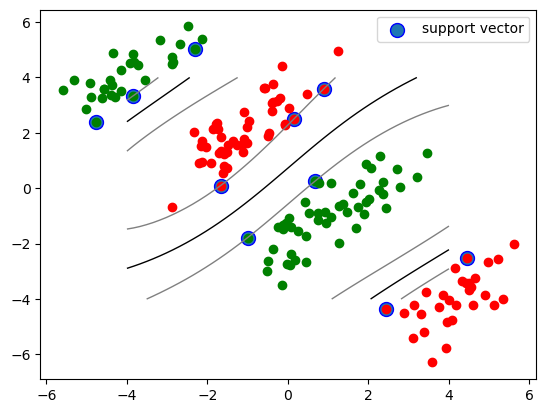

In [35]:
def plot_classifier(X1_train, X2_train, clf):
    plt.plot(X1_train[:,0], X1_train[:,1], "ro")
    plt.plot(X2_train[:,0], X2_train[:,1], "go")
    plt.scatter(non_linear_svm.spv[:,0], non_linear_svm.spv[:,1], 
                s=100, edgecolors="b", label="support vector")

    X1, X2 = np.meshgrid(np.linspace(-4,4,50), np.linspace(-4,4,50))
    X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
    Z = non_linear_svm.project(X).reshape(X1.shape)
    plt.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
    plt.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
    plt.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')
    plt.legend()
    plt.show()
    
plot_classifier(X_train[y_train==1], X_train[y_train==-1], non_linear_svm)